In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Data
Load solver metadata, problem metadata, and solving information.

In [2]:
solver_data  = pd.read_csv('solvers.csv')
problem_data = pd.read_csv('all-instances.csv')
data         = pd.read_csv('solver-comparison-with-deletion.csv')

# solvers = set(data['solver'])
solvers = [
    'maplesat',
#     'xmaplesat_rnd_rep0_force0',
#     'xmaplesat_rnd_rep0_force1',
    'xmaplesat_rnd_rep1_force0',
    'xmaplesat_rnd_rep1_force1',
#     'xmaplesat_sub_rep0_force0',
#     'xmaplesat_sub_rep0_force1',
    'xmaplesat_sub_rep1_force0',
    'xmaplesat_sub_rep1_force1'
]
solvers

['maplesat',
 'xmaplesat_rnd_rep1_force0',
 'xmaplesat_rnd_rep1_force1',
 'xmaplesat_sub_rep1_force0',
 'xmaplesat_sub_rep1_force1']

# Data Cleaning
If the instance could not be solved, set its solving time equal to the maximum value.

Drop any instances for which data could not be collected or for which solving time is 0.

In [3]:
max_cpu_time = 5000
# Set time equal to max if instance could not be solved
data['cpu_time'] = data.apply(lambda row: max_cpu_time if row['satisfiability'] == 'INDETERMINATE' else row['cpu_time'], axis=1)
data['cpu_time'] = data['cpu_time'].apply(lambda val: val if val else np.nan)
data = data.dropna()

data        ['problem'      ] = data        ['problem']      .apply(lambda val: val.strip())
problem_data['instance_path'] = problem_data['instance_path'].apply(lambda val: val.strip())

# Compute normalized statistics

In [4]:
# Set time equal to max if instance could not be solved
data['adjusted_time'] = data.apply(lambda row: row['cpu_time'    ] - row['er_time'      ], axis=1)
data['adjusted_time'] = data.apply(lambda row: max_cpu_time if row['satisfiability'] == 'INDETERMINATE' else row['adjusted_time'], axis=1)

data['overhead_frac'] = data.apply(lambda row: row['er_time'     ] / row['cpu_time'     ], axis=1)
data['conf_per_dec' ] = data.apply(lambda row: row['conflicts'   ] / row['decisions'    ], axis=1)
data['prop_per_dec' ] = data.apply(lambda row: row['propagations'] / row['decisions'    ], axis=1)
data['conf_per_sec' ] = data.apply(lambda row: row['conflicts'   ] / row['adjusted_time'], axis=1)
data['avg_lbd'      ] = data.apply(lambda row: row['total_lbd'   ] / row['conflicts'    ] if row['conflicts'] else np.nan, axis=1)
data['ev_conf_frac' ] = data.apply(lambda row: row['ev_conflicts'] / row['conflicts'    ] if row['conflicts'] else np.nan, axis=1)
data['conf_per_ev'  ] = data.apply(lambda row: row['ev_conflicts'] / row['num_ev'       ] if row['num_ev'   ] else np.nan, axis=1)

In [5]:
x = problem_data.set_index('instance_path')
data['category'] = data['problem'].apply(lambda val: x.loc[val, ['category']])

# Explanation of Columns
Here, we list the statistics which are captured from running the solvers. Normalized statistics are computed and described later.

## Solver Configuration
* `solver`: Solver name
* `heuristic`: Heuristic used for introducing extension variables
* `sub_defn`: Substitute extension variables into clauses where their definitions occur
* `ext_freq`: How often to try introducing extension variables (minimum number of conflicts that must have occurred before searching for an extension variable)
* `window_size`: Maximum number of clauses to consider when introducing a new extension variable
* `max_new_ev`: Maximum number of new extension variables to introduce at once
* `force_branch`: Whether to force branching on new extension variables

## Problem Metadata
* `instance_path`: Absolute path to the problem instance
* `n`: Number of variables
* `m`: Number of clauses
* `category`: Problem class - can be one of:
    * `agile`
    * `crafted`
    * `crypto`
    * `random`
    * `verification`

## Base Solver Performance Statistics
* `problem`: The name of the CNF instance
* `restarts`: The total number of restarts
* `conflicts`: The total number of conflicts
* `decisions`: The total number of decisions
* `propagations`: The total number of propagations
* `conf_lits`: The total number of conflict literals
* `num_ev`: The total number of extension variables introduced
* `ev_decisions`: The total number of decisions on an extension variable
* `ev_conflicts`: The total number of times a clause containing extension variables participates in a conflict
* `ev_learnt`: The total number of times a learnt clause contains an extension variable
* `total_lbd`: The total Literal Block Distance of all learnt clauses
* `mem_used`: The total amount of memory (in MB) used for the instance
* `cpu_time`: The total amount of time (in seconds) used for the instance
* `er_time`: The total amount of time (in seconds) used for doing work related to Extended Resolution (e.g., searching for a new extension variable)
* `satisfiability`: The computed satisfiability of the formula

## Computed Solver Performance Statistics
* `adjusted_time`: CPU time - overhead associated with Extended Resolution
* `overhead_frac`: The fraction of total time taken for Extended Resolution
* `conf_per_dec`: The number of conflicts per decision (a.k.a. GLR: Global Learning Rate)
* `prop_per_dec`: The number of propagations per decision
* `conf_per_sec`: The number of conflicts per second (using adjusted time)
* `avg_lbd`: The average LBD (literal block distance) per learnt clause
* `ev_conf_frac`: The proportion of all conflicts which involve conflict clauses
* `conf_per_ev`: The average number of conflicts involving an extension clause per extension variable

In [6]:
solver_data

,solver,heuristic,sub_defn,ext_freq,window_size,max_new_ev,force_branch
0,maplesat,none,NaN,NaN,NaN,NaN,NaN
1,xmaplesat_rnd_rep0_force0,random,0.0,2000.0,100.0,10.0,0.0
2,xmaplesat_rnd_rep0_force1,random,0.0,2000.0,100.0,10.0,1.0
3,xmaplesat_rnd_rep1_force0,random,1.0,2000.0,100.0,10.0,0.0
4,xmaplesat_rnd_rep1_force1,random,1.0,2000.0,100.0,10.0,1.0
5,xmaplesat_sub_rep1_force1,subexpression,1.0,2000.0,100.0,10.0,1.0
6,xmaplesat_sub_rep0_force0,subexpression,0.0,2000.0,100.0,10.0,0.0
7,xmaplesat_sub_rep0_force1,subexpression,0.0,2000.0,100.0,10.0,1.0
8,xmaplesat_sub_rep1_force0,subexpression,1.0,2000.0,100.0,10.0,0.0


In [7]:
problem_data

,instance_path,n,m,category
0,/scratch/jt2chung/parameters_of_industiral/agi...,12055,66378,agile
1,/scratch/jt2chung/parameters_of_industiral/agi...,1787,9140,agile
2,/scratch/jt2chung/parameters_of_industiral/agi...,15298,74904,agile
3,/scratch/jt2chung/parameters_of_industiral/agi...,1785,9115,agile
4,/scratch/jt2chung/parameters_of_industiral/agi...,1790,9207,agile
...,...,...,...,...
6992,/scratch/jt2chung/xMaplesatExperiments/instanc...,400,5,random
6993,/scratch/jt2chung/xMaplesatExperiments/instanc...,400,6,random
6994,/scratch/jt2chung/xMaplesatExperiments/instanc...,400,7,random
6995,/scratch/jt2chung/xMaplesatExperiments/instanc...,400,8,random


# Summarize Solver Performance

Compute percentage overhead for each ER solver variant.

,overhead_frac
,mean
solver,
maplesat,0.000008
xmaplesat_rnd_rep0_force0,0.039255
xmaplesat_rnd_rep0_force1,0.038369
xmaplesat_rnd_rep1_force0,0.299700
xmaplesat_rnd_rep1_force1,0.297924
xmaplesat_sub_rep0_force0,0.065344
xmaplesat_sub_rep0_force1,0.063624
xmaplesat_sub_rep1_force0,0.201673


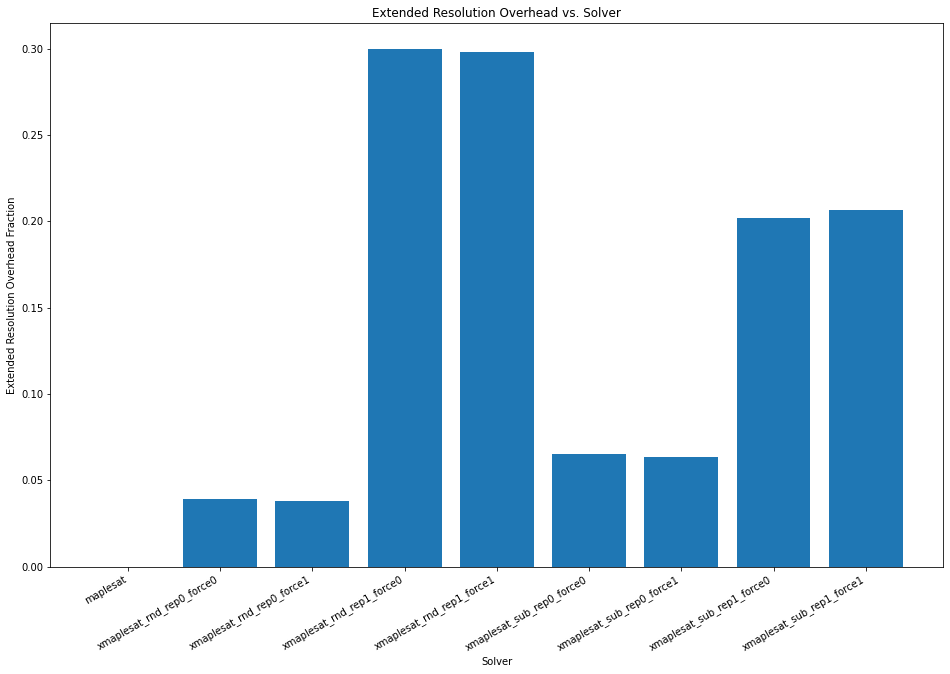

In [8]:
overhead_summary = data.groupby('solver').agg({'overhead_frac': ['mean']})
fig, ax = plt.subplots()
ax.bar(overhead_summary.index, overhead_summary['overhead_frac']['mean'])
ax.set_title(f'Extended Resolution Overhead vs. Solver')
ax.set_xlabel('Solver')
ax.set_ylabel('Extended Resolution Overhead Fraction')
fig.set_figwidth(16)
fig.set_figheight(10)

def rotateAxisLabels(ax, angle):
    for label in ax.get_xticklabels():
        label.set_rotation(angle)
        label.set_ha('right')

rotateAxisLabels(ax, 30)
overhead_summary

# Visualize Data

In [9]:
# Separate problems by variant
problem_variants = set(problem_data['category'])

def cactusForData(data, solvers, axis_y, label_y, title_label, log_scale=True):
    # Plot data
    fig, ax = plt.subplots()
    markers = ['o', '^', 's', '*', 'x', 'P', '1', 'v', '2', '<', '3', '>', '4', '8']
    for i, solver in enumerate(solvers):
        solver_series = data[data['solver']==solver].reset_index(drop=True)
        ax.plot(solver_series.index, solver_series[axis_y], label=solver, marker=markers[i])

    # Format plot
    fig.set_figwidth(16)
    fig.set_figheight(10)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    ax.set_title(f'{label_y} vs. Benchmarks ({title_label})')
    ax.set_xlabel('Number of Benchmarks')
    ax.set_ylabel(label_y)
    if log_scale: ax.semilogy()

    # Rotate axis label names
    # rotateAxisLabels(ax, 15)

def cactusByVariant(solvers, axis_y, label_y, log_scale=True):
    sorted_data = data.sort_values(by=axis_y)
    cactusForData(sorted_data, solvers, axis_y, label_y, 'All', log_scale)
    for variant in problem_variants:
        # Plot data
        problem_series = sorted_data[sorted_data['category'] == variant]
        cactusForData(problem_series, solvers, axis_y, label_y, variant, log_scale)

## Total Time (s) vs. Instance

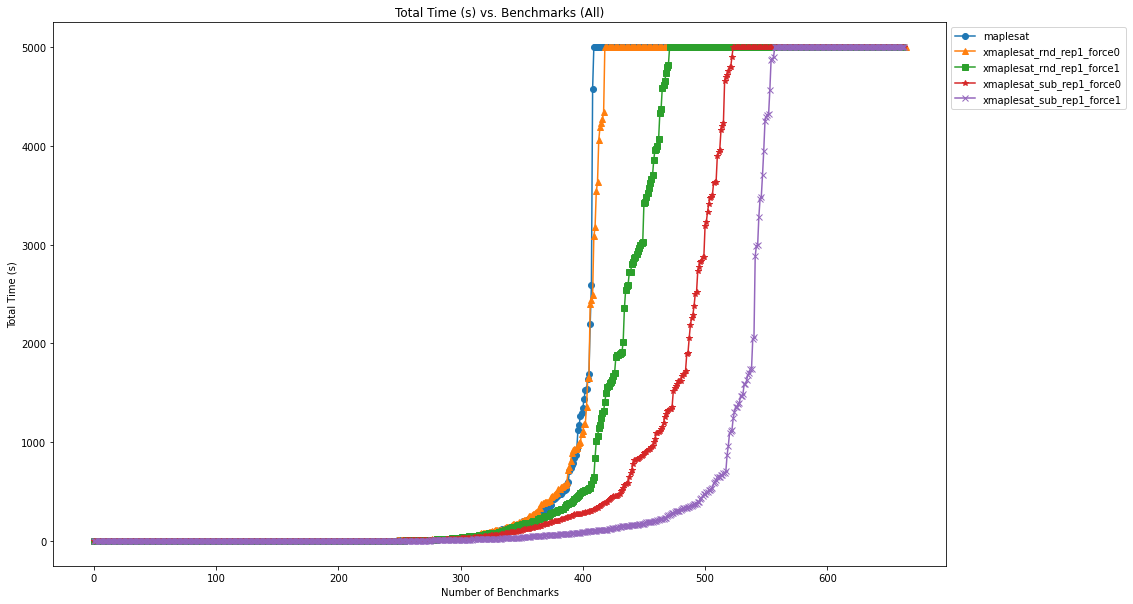

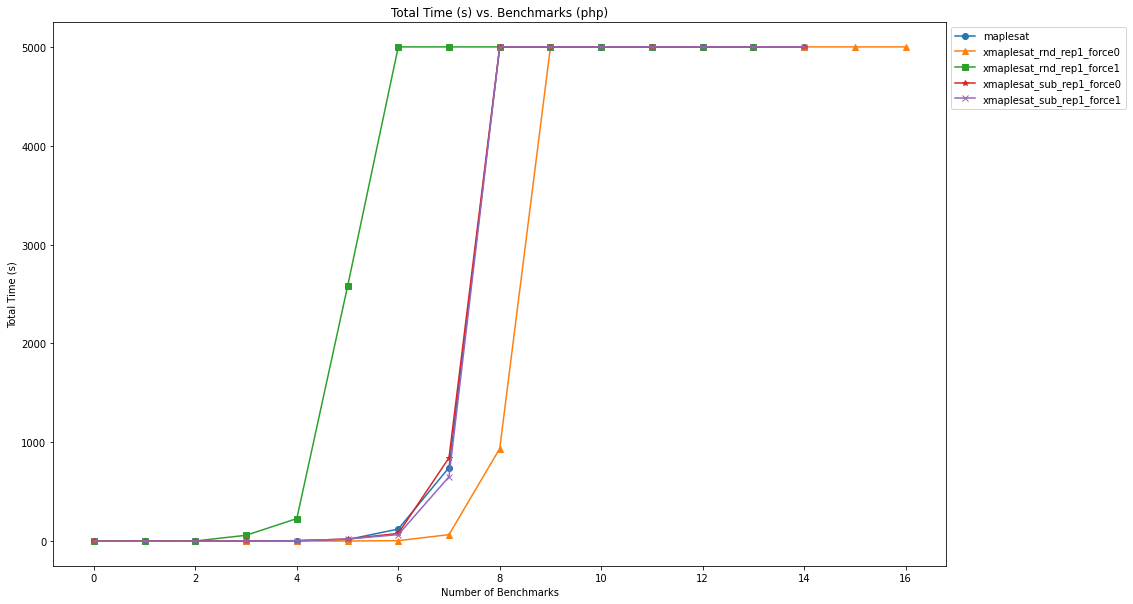

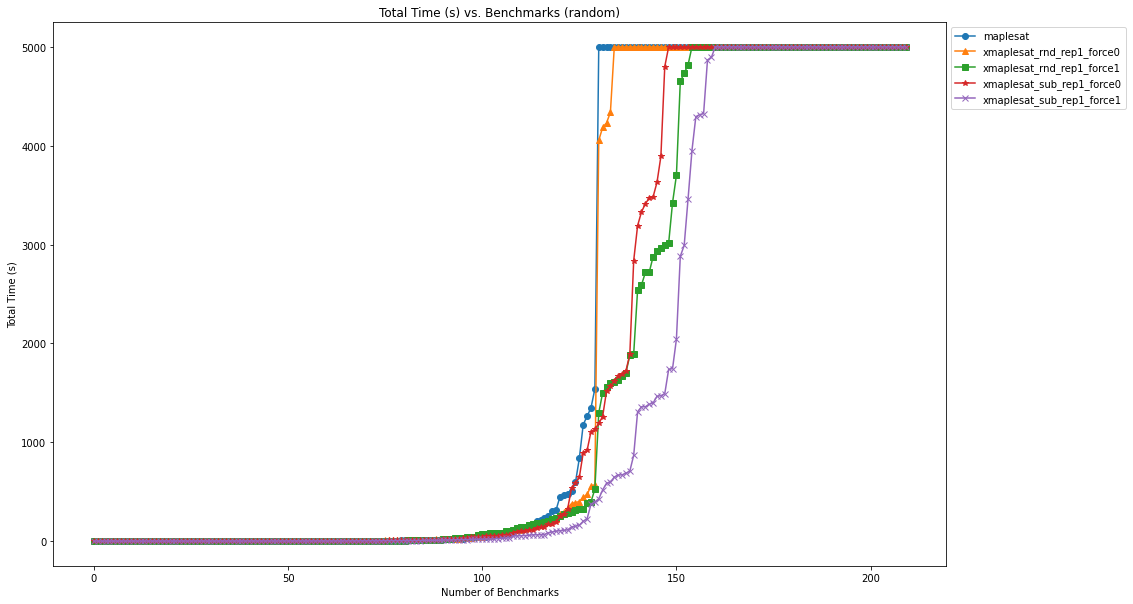

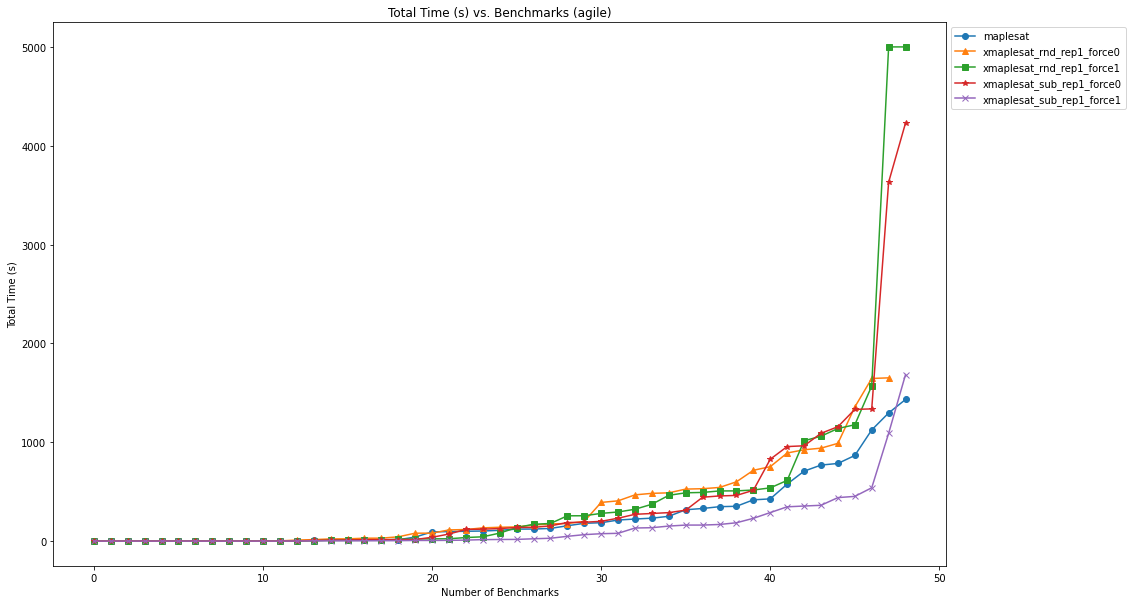

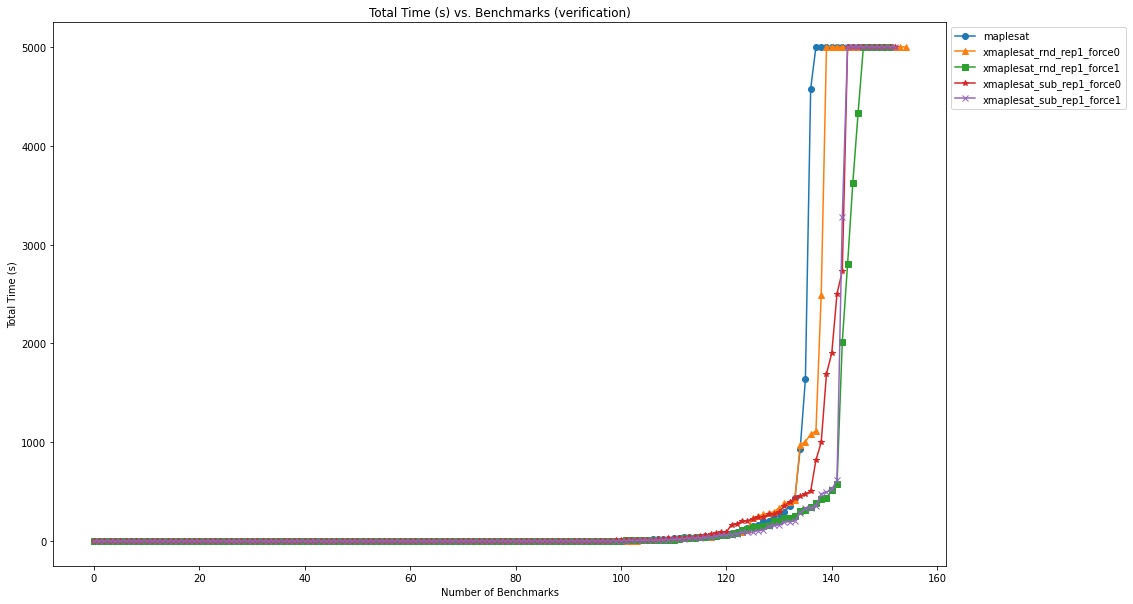

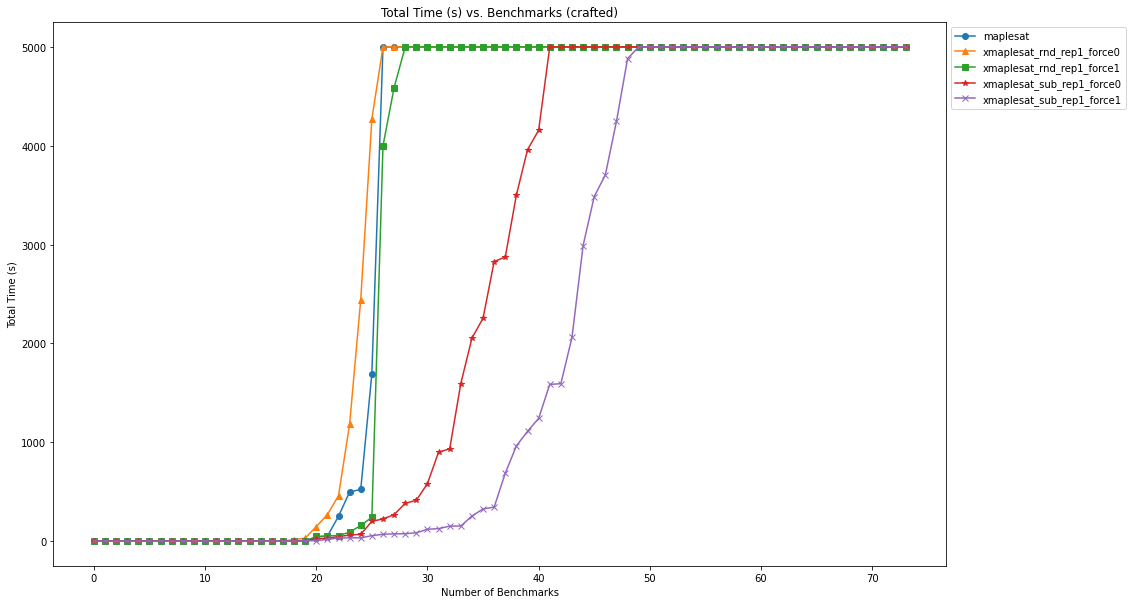

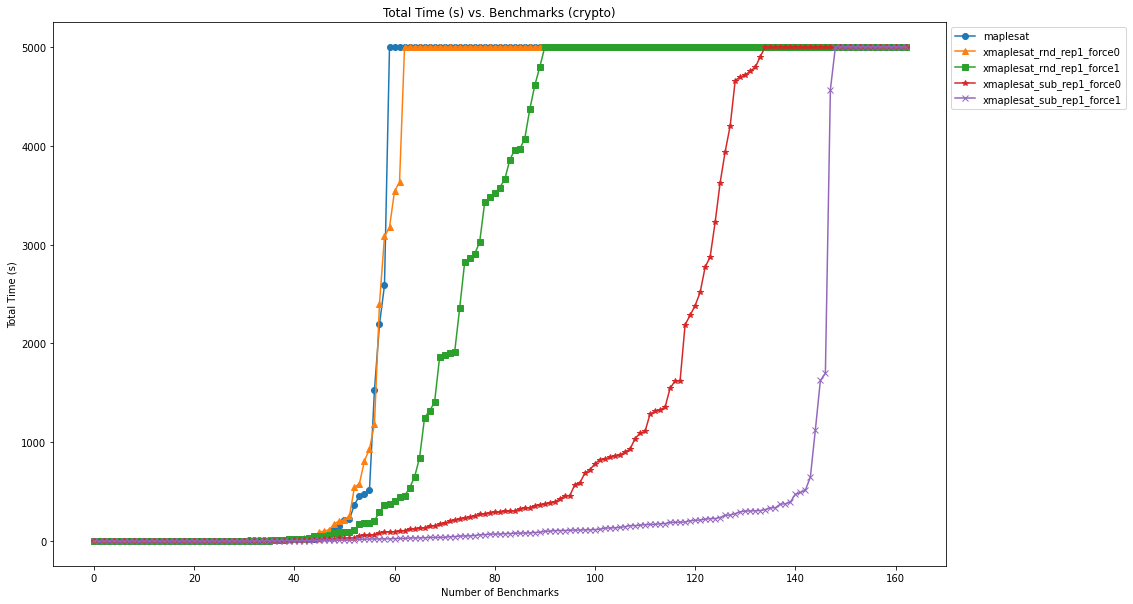

In [10]:
cactusByVariant(solvers, 'cpu_time', 'Total Time (s)',False)

## Time without Overhead (s) vs. Instance

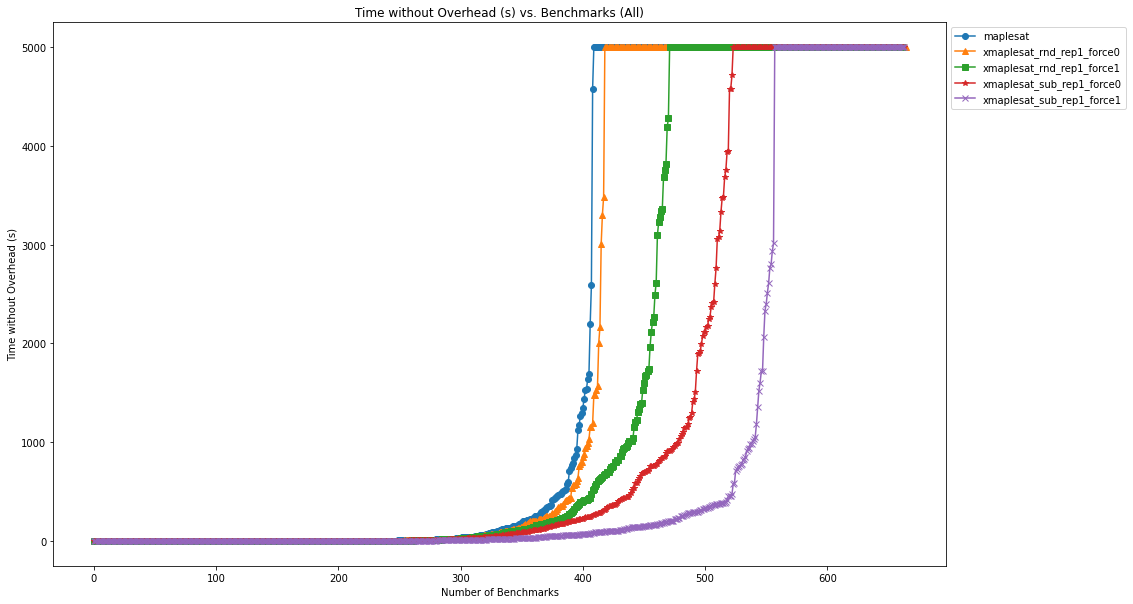

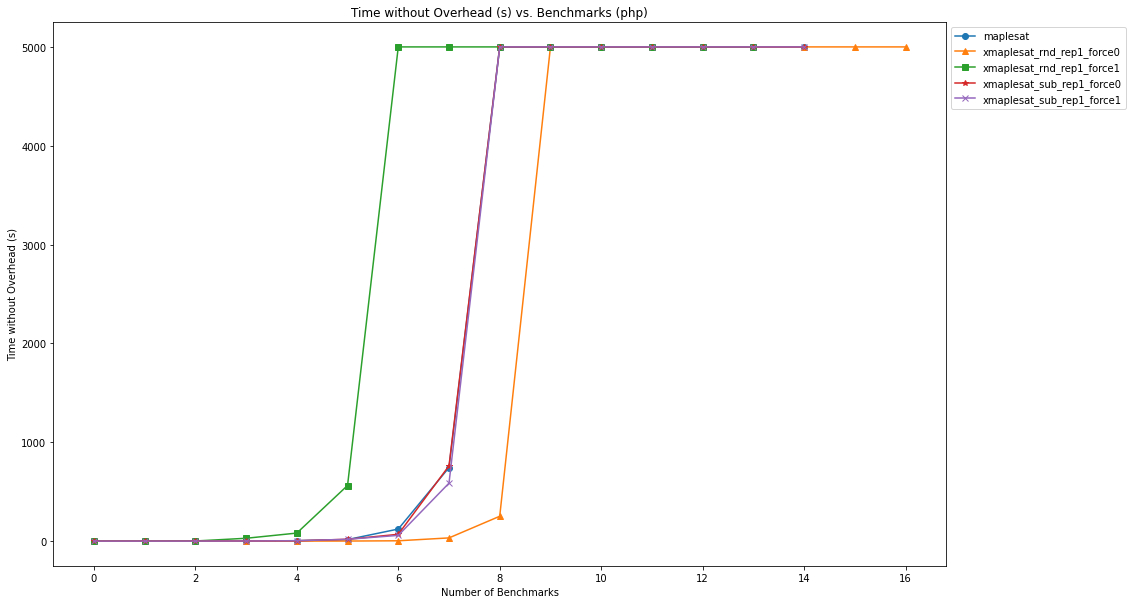

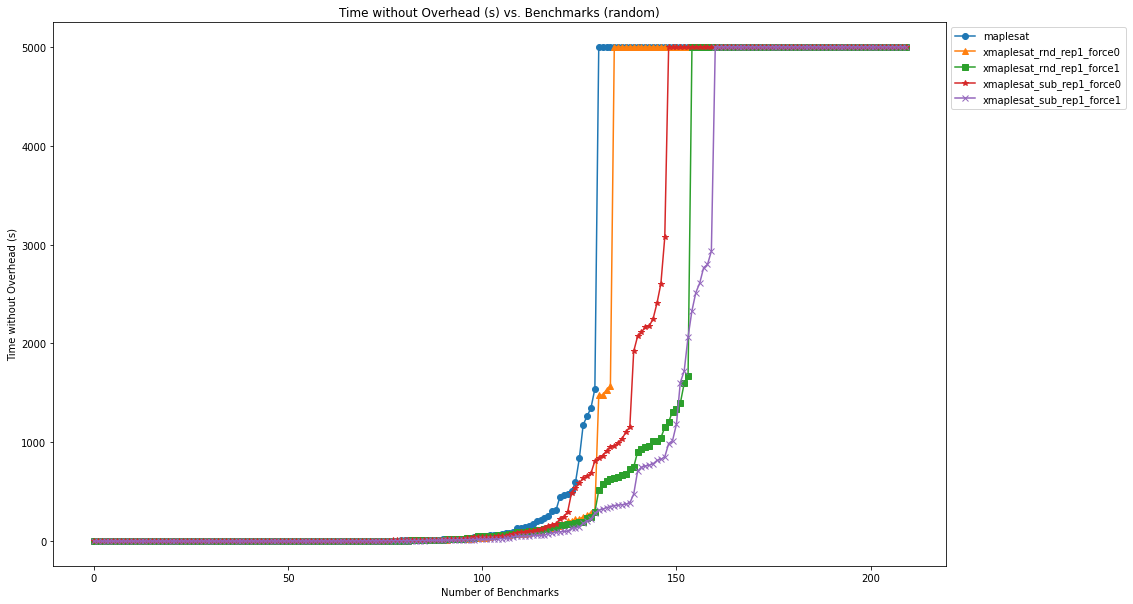

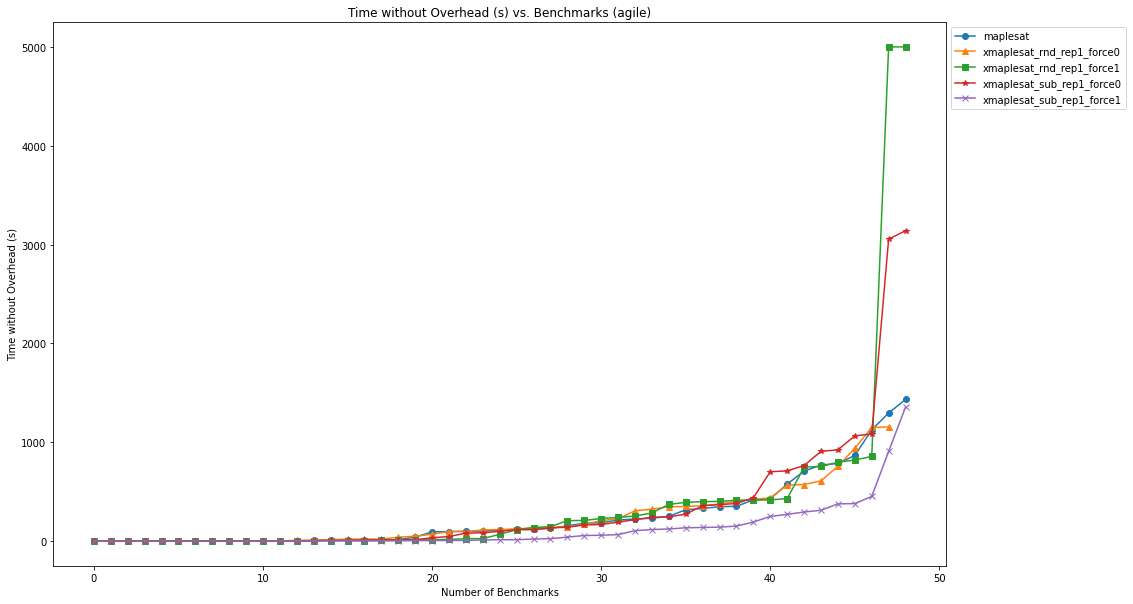

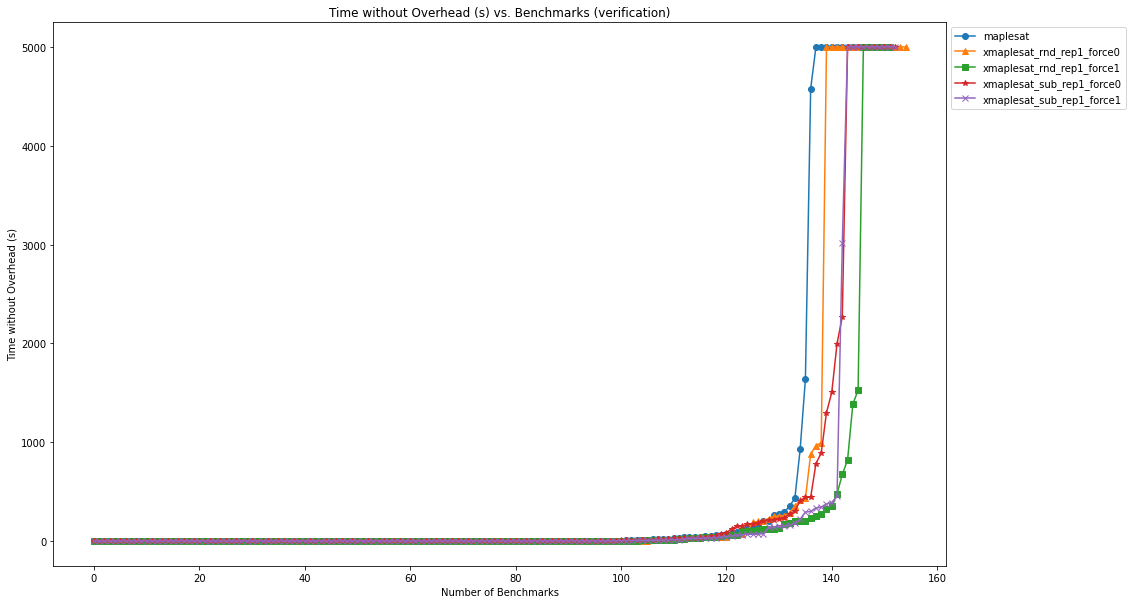

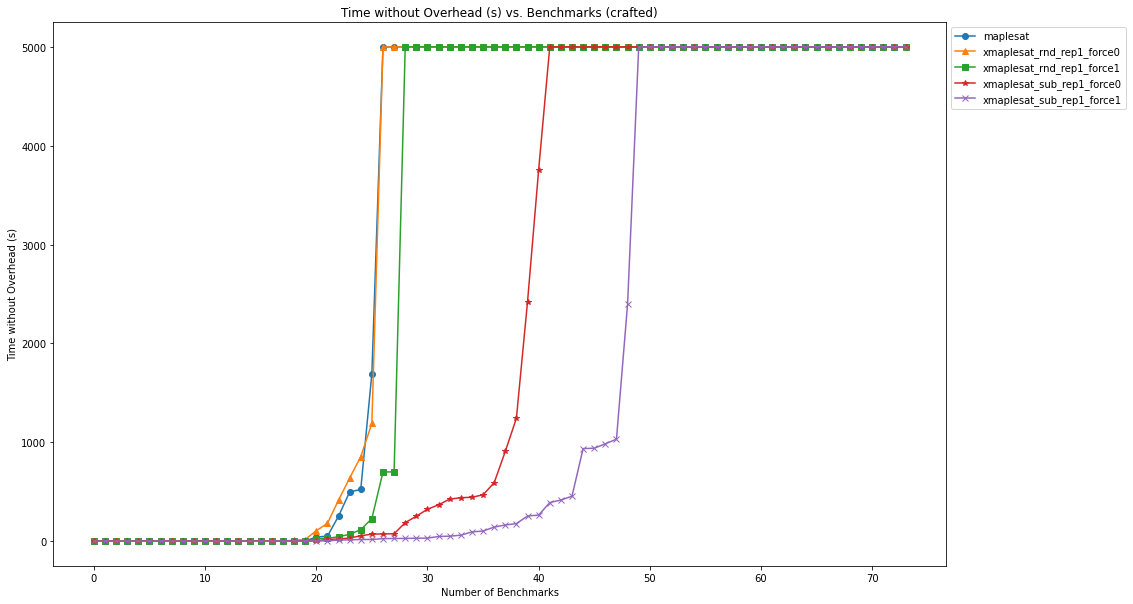

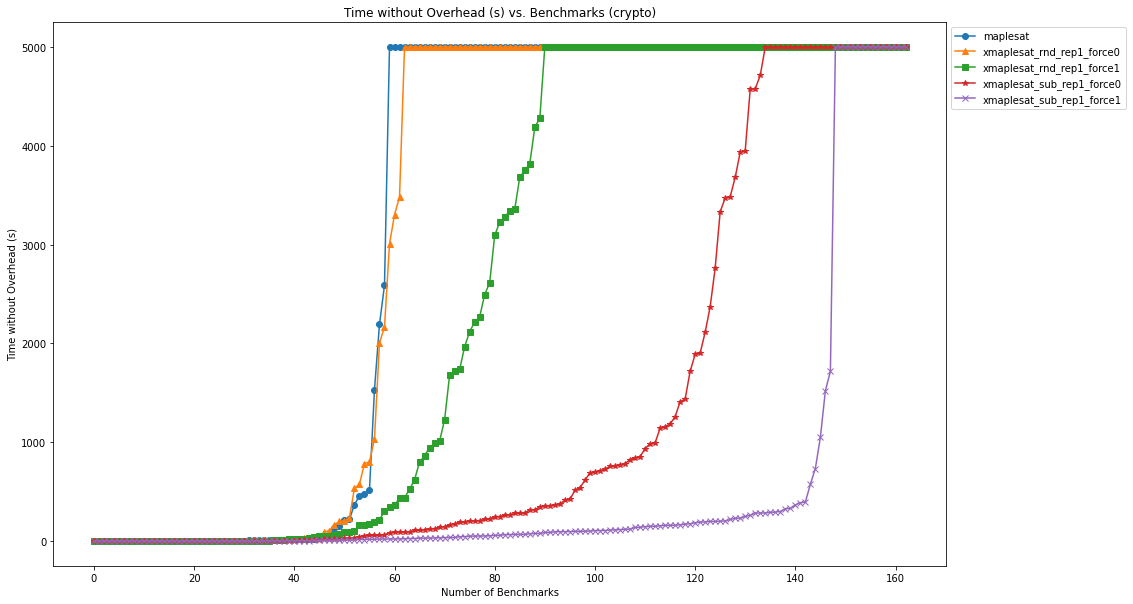

In [11]:
cactusByVariant(solvers, 'adjusted_time', 'Time without Overhead (s)', False)

## GLR vs. Instance

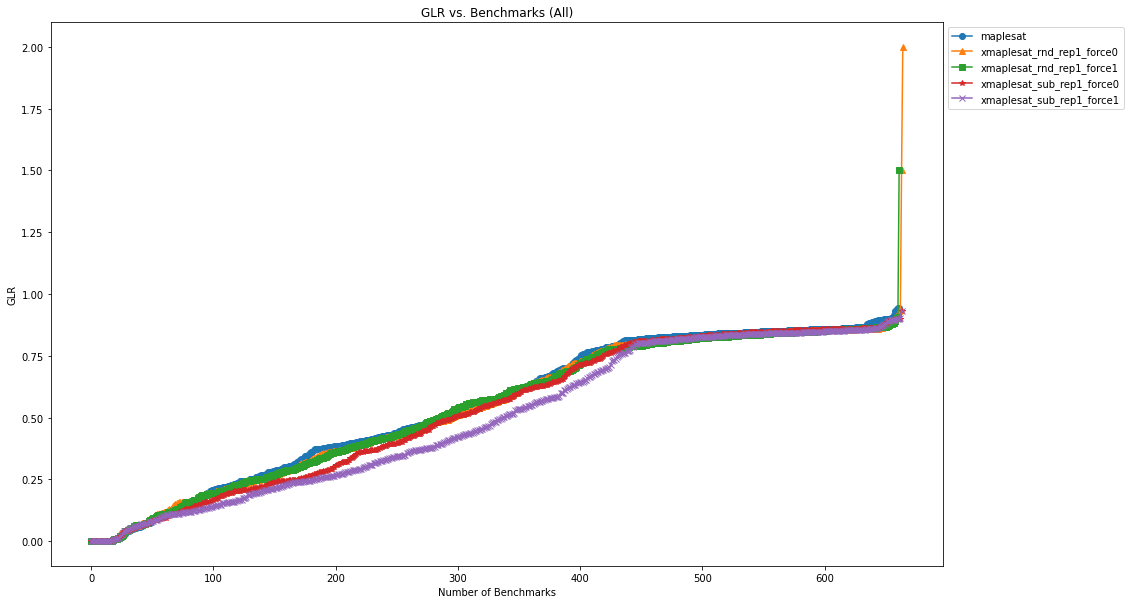

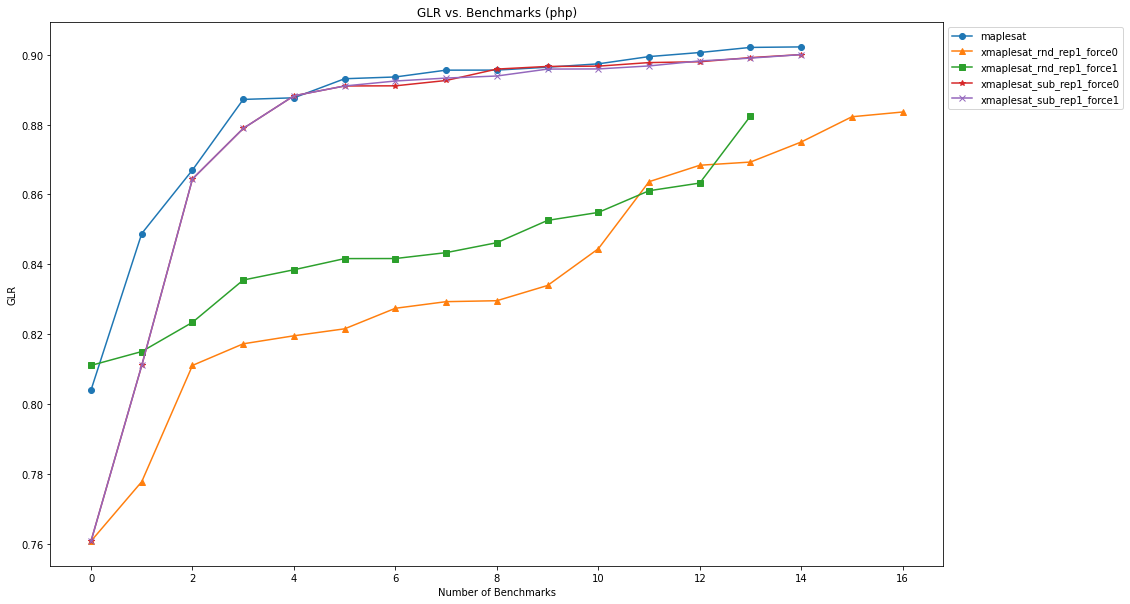

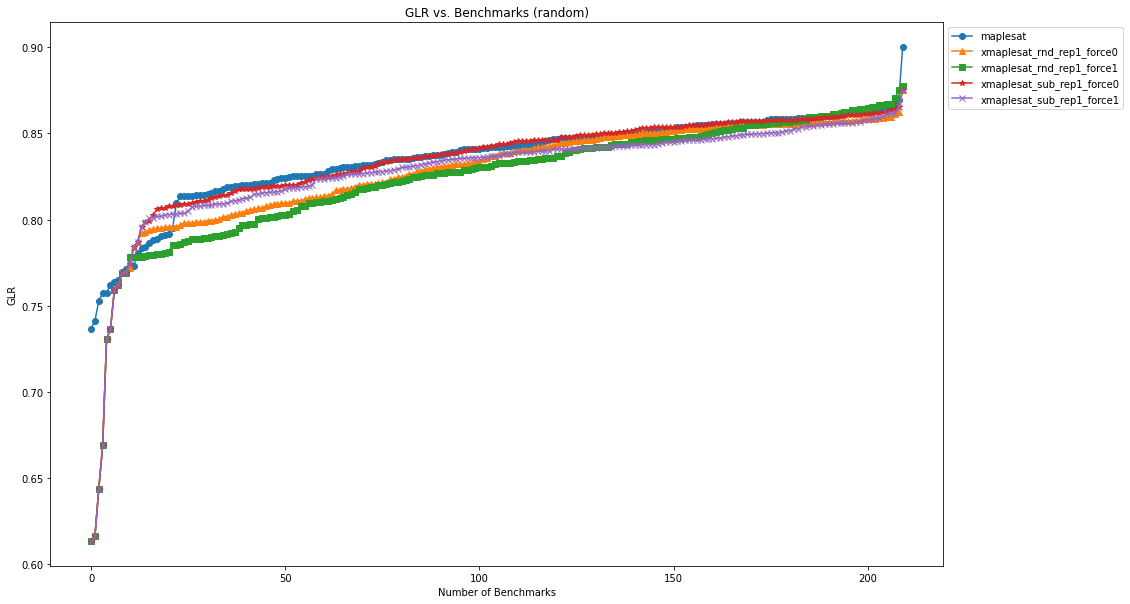

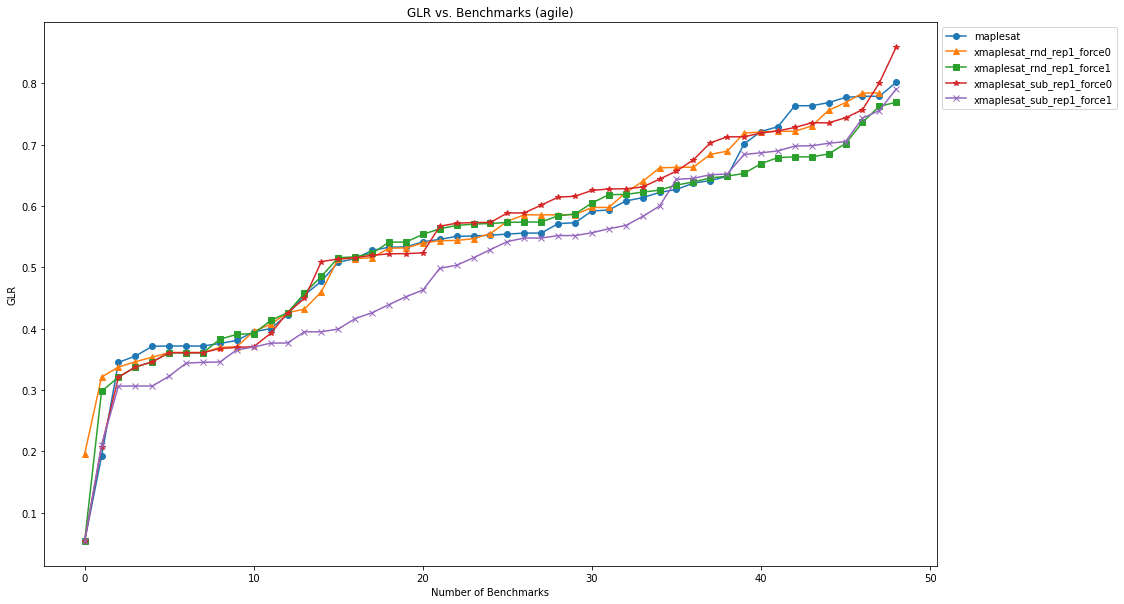

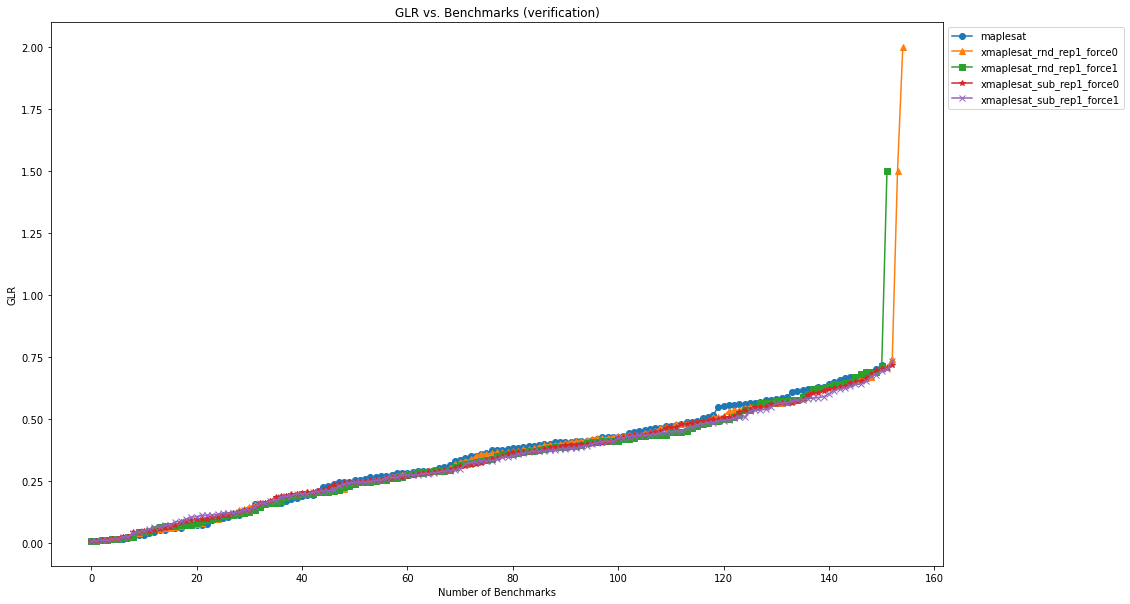

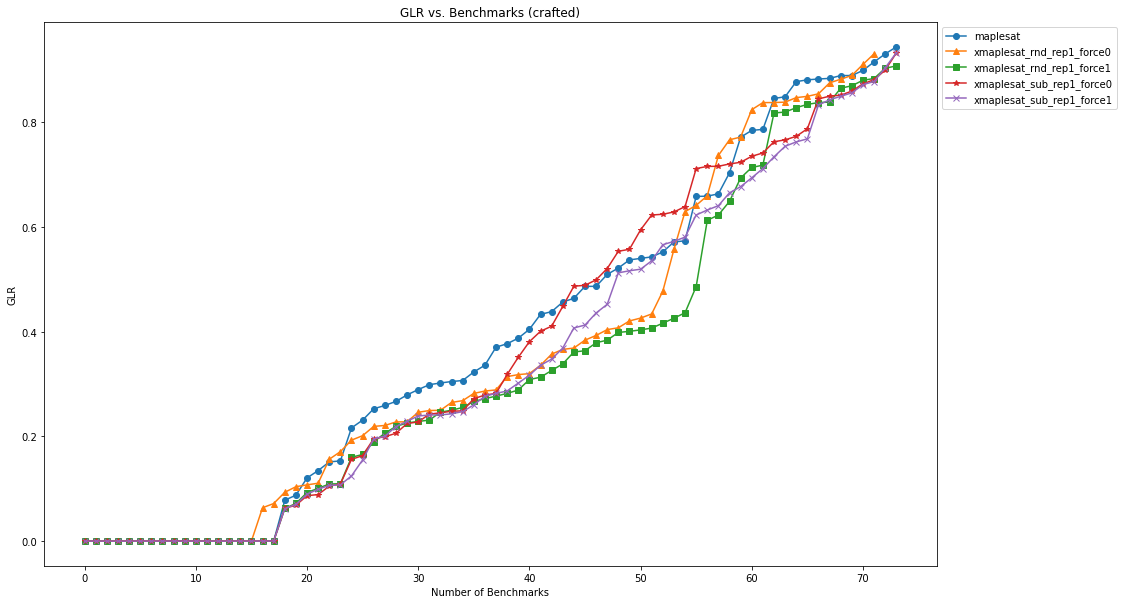

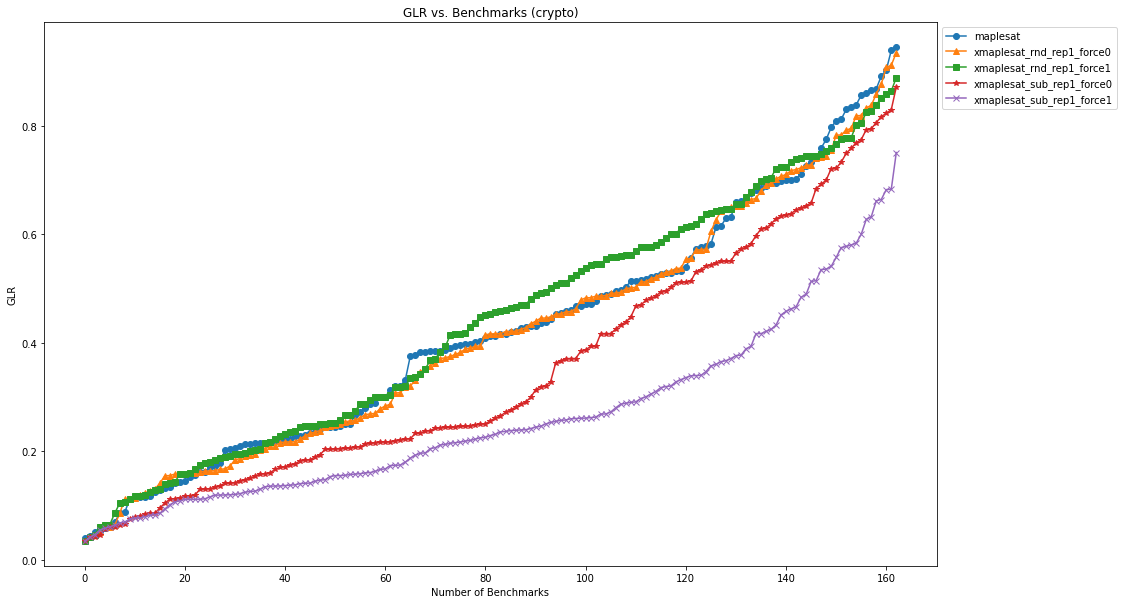

In [12]:
cactusByVariant(solvers, 'conf_per_dec', 'GLR',False)

## Average LBD vs. Instance

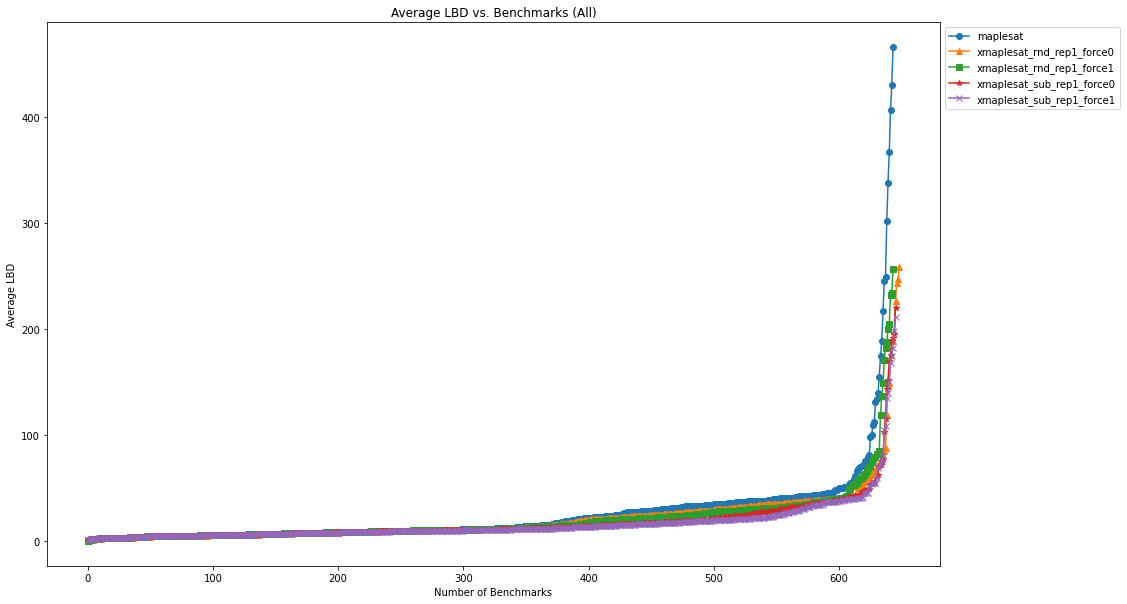

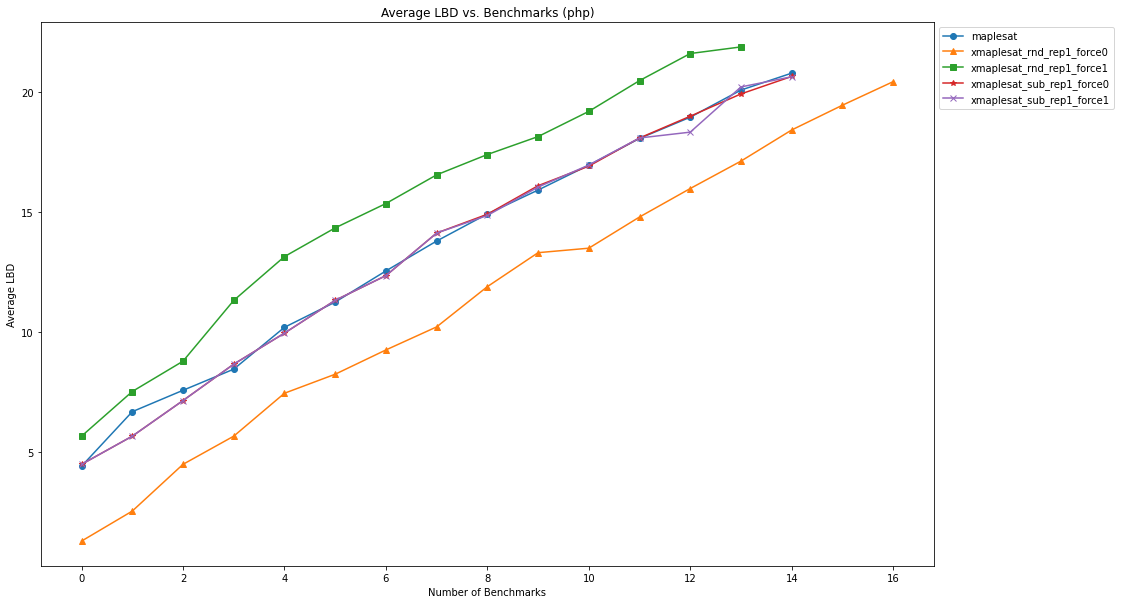

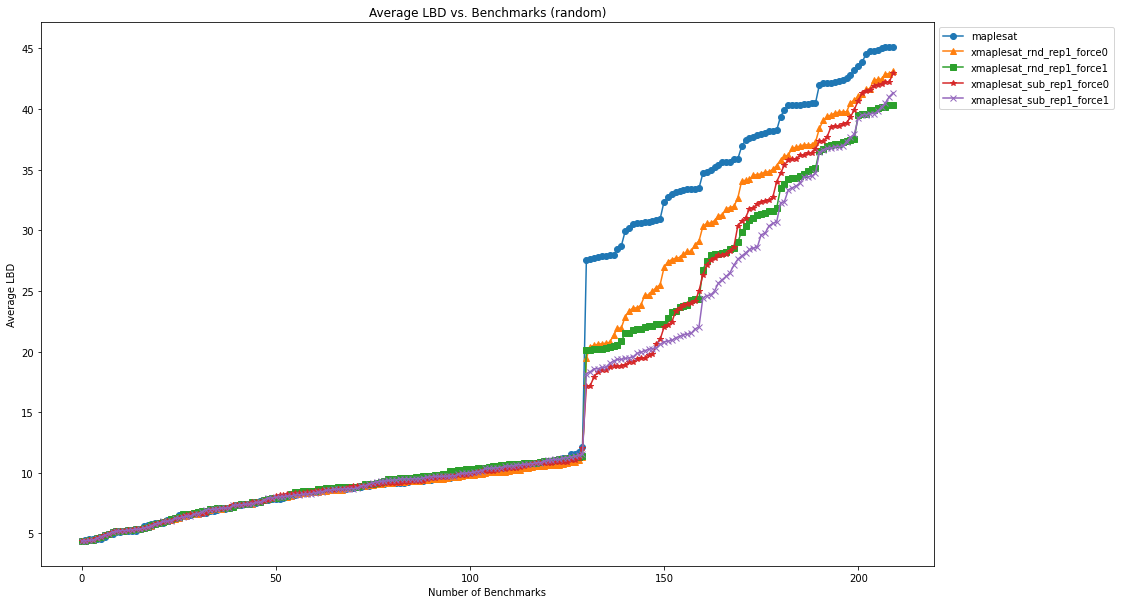

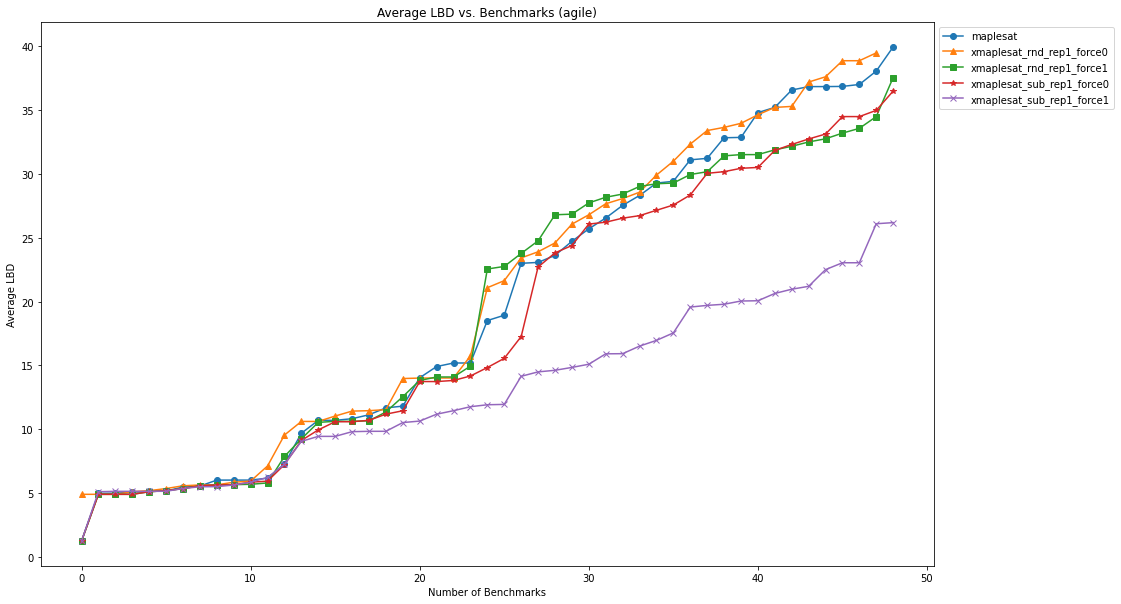

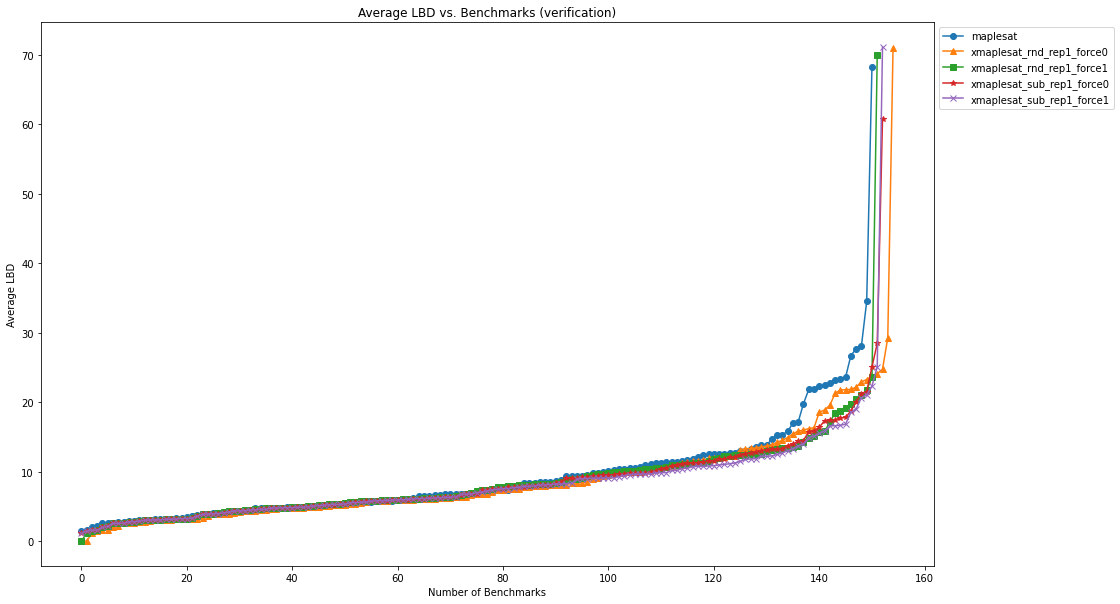

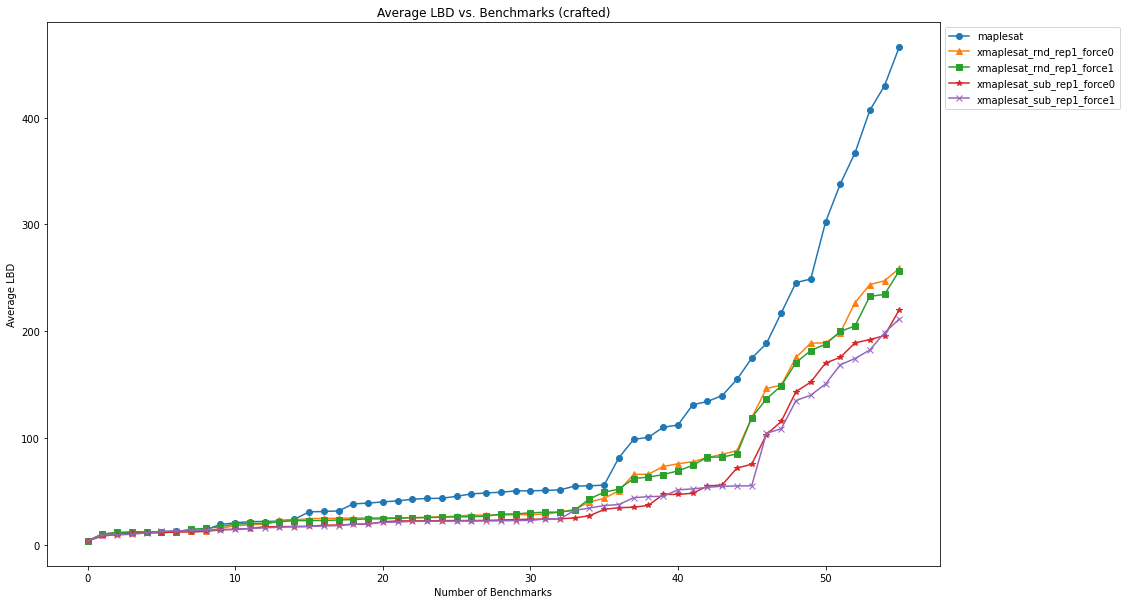

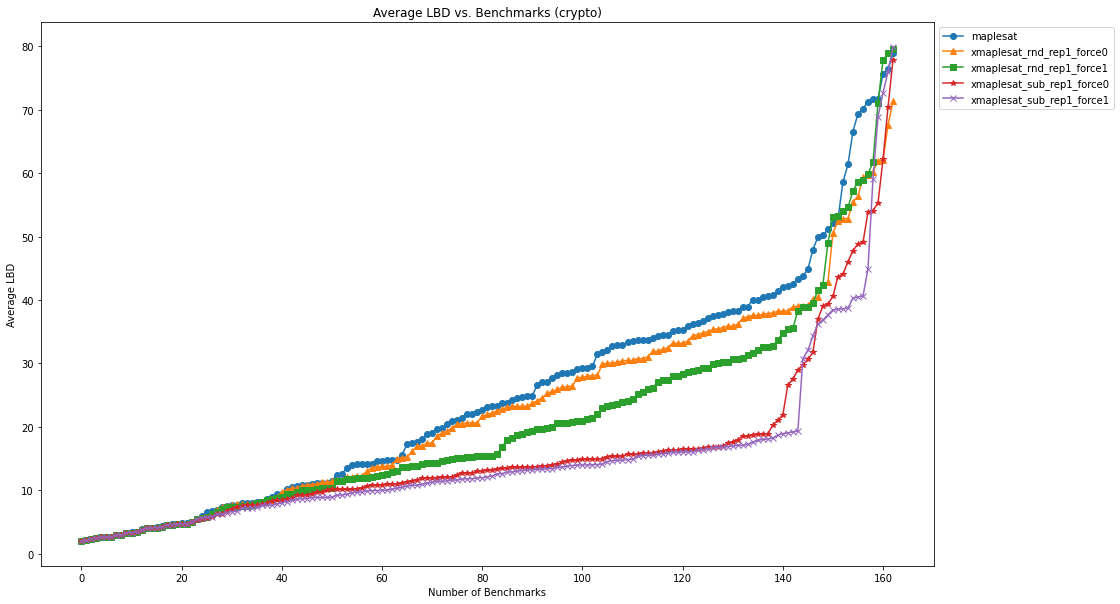

In [13]:
cactusByVariant(solvers, 'avg_lbd', 'Average LBD',False)

## Number of Extension Variables vs. Instance

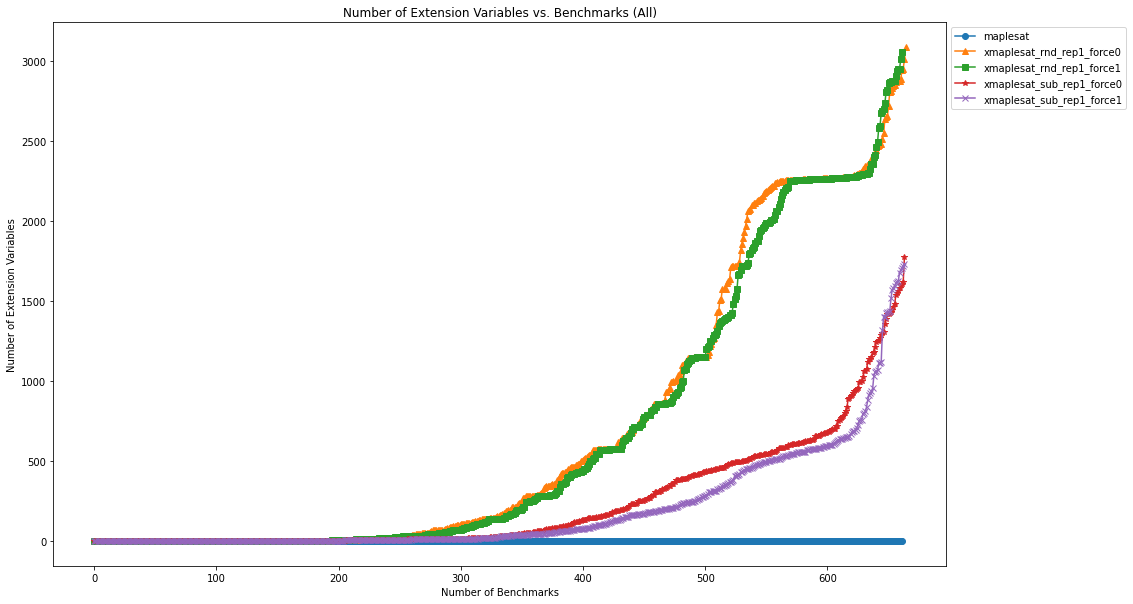

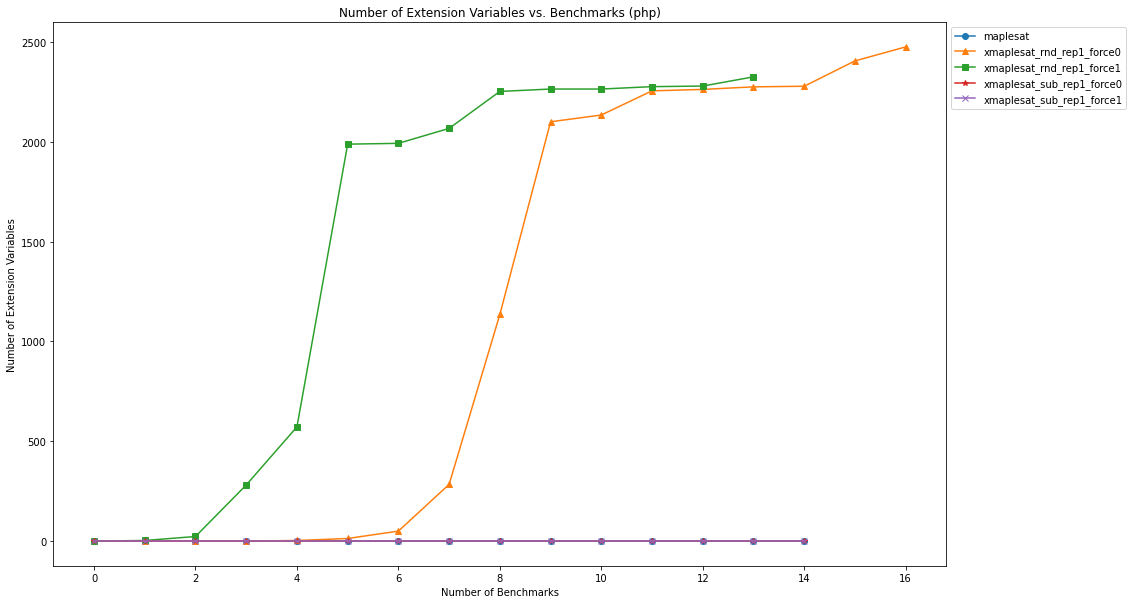

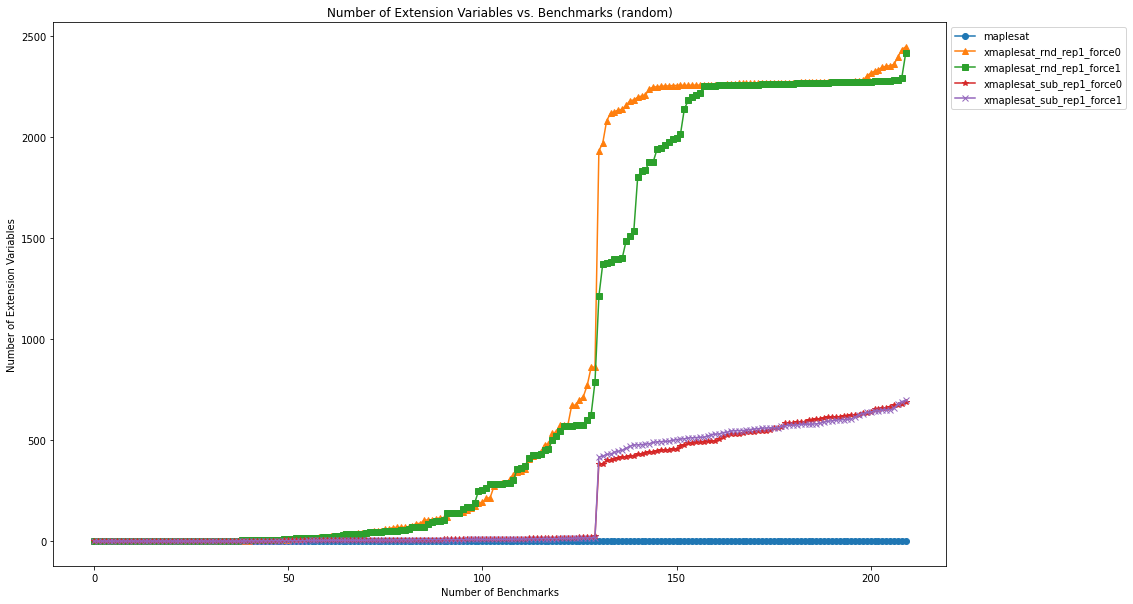

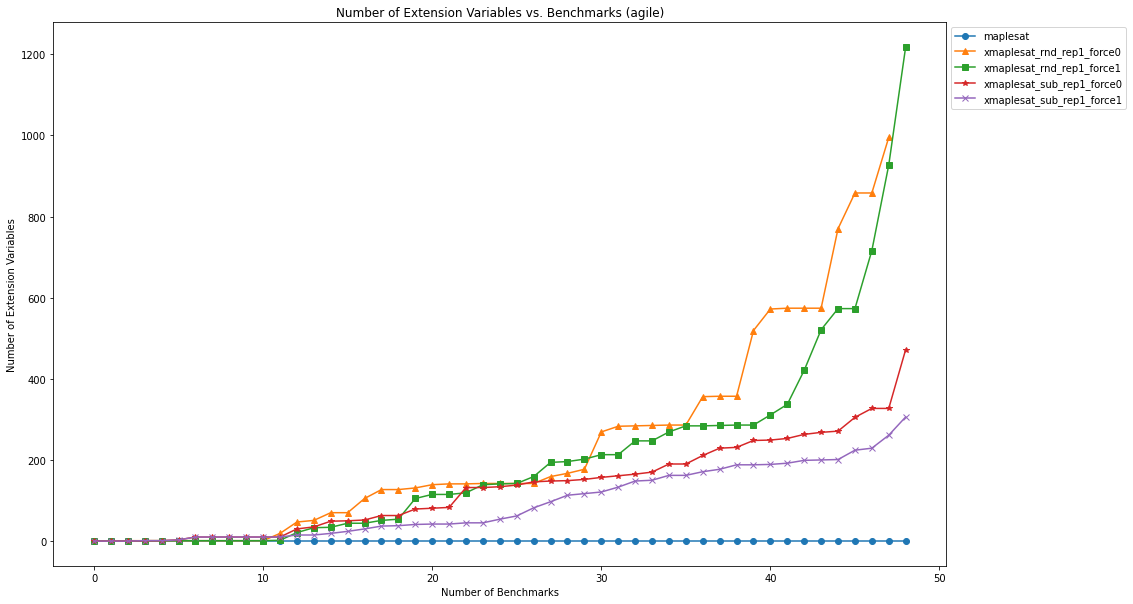

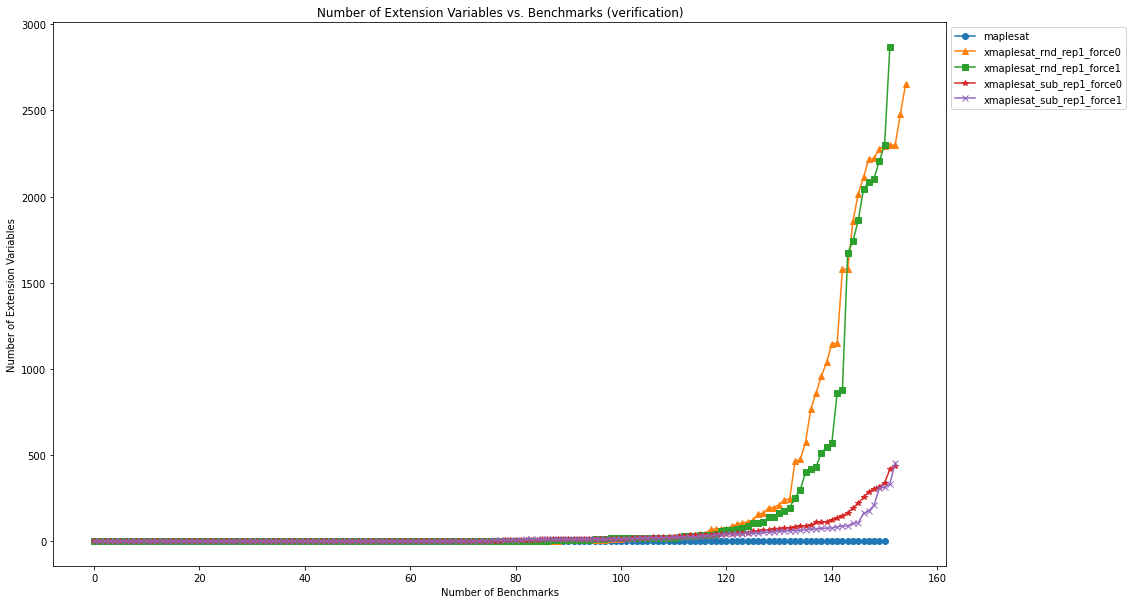

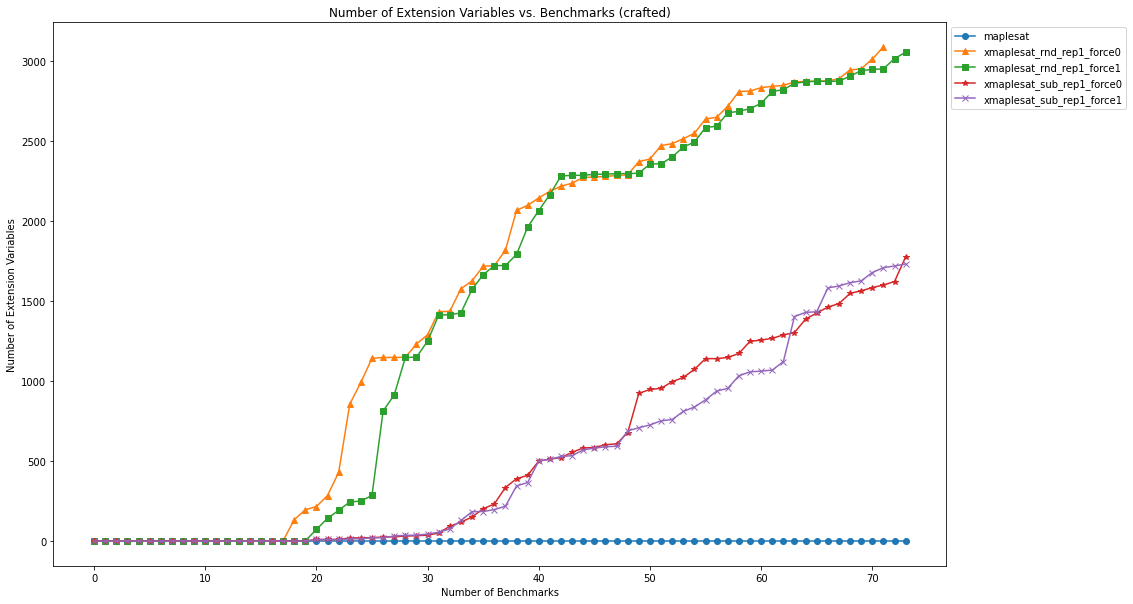

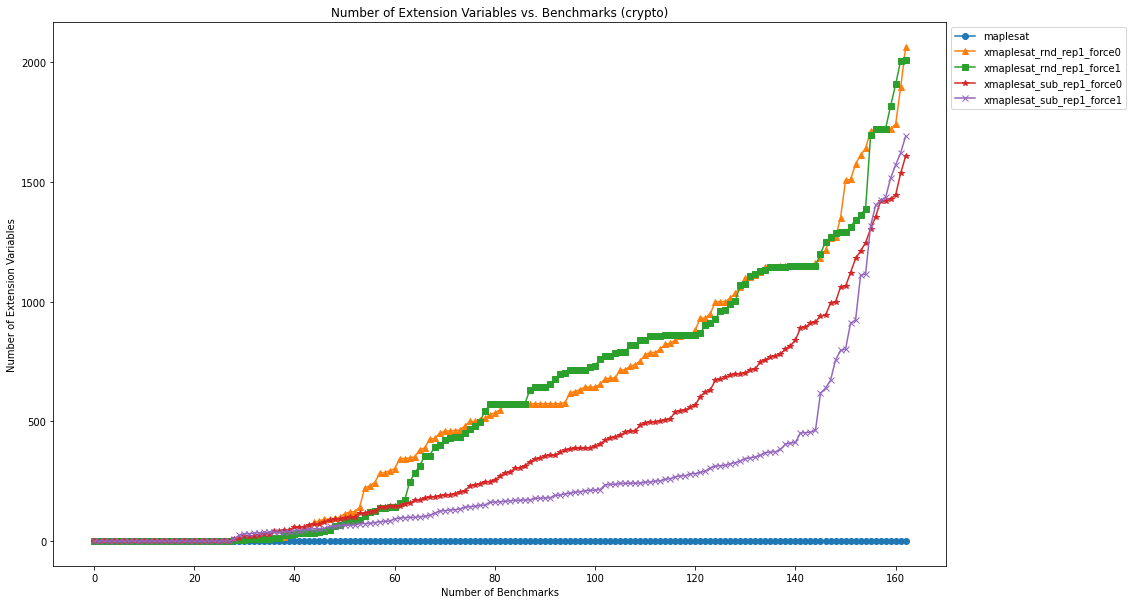

In [14]:
cactusByVariant(solvers, 'num_ev', 'Number of Extension Variables', False)

## Extension Clause Conflict Fraction vs. Instance

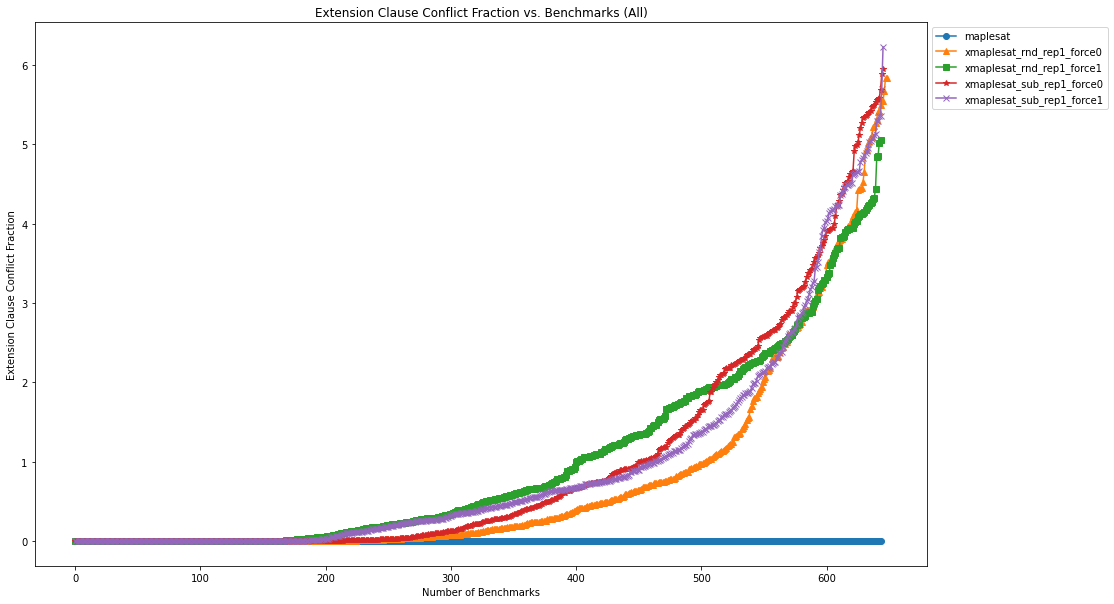

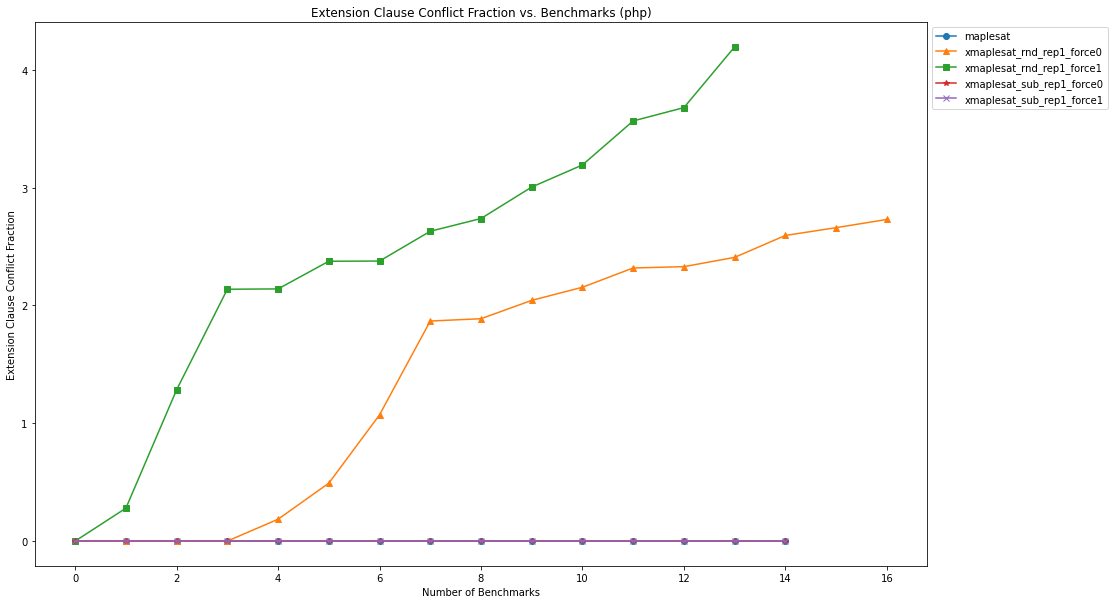

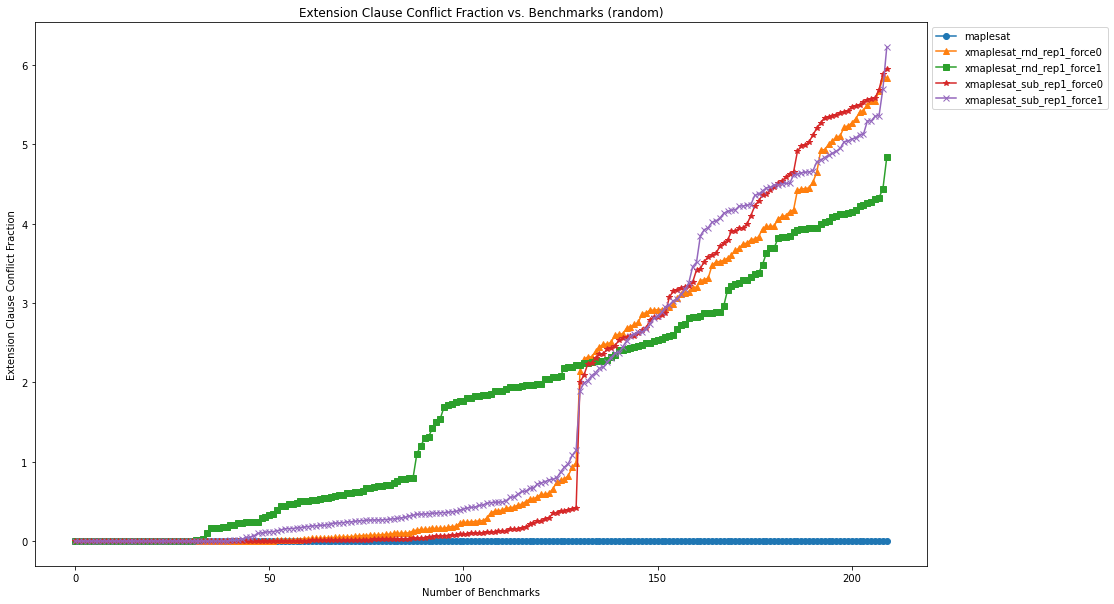

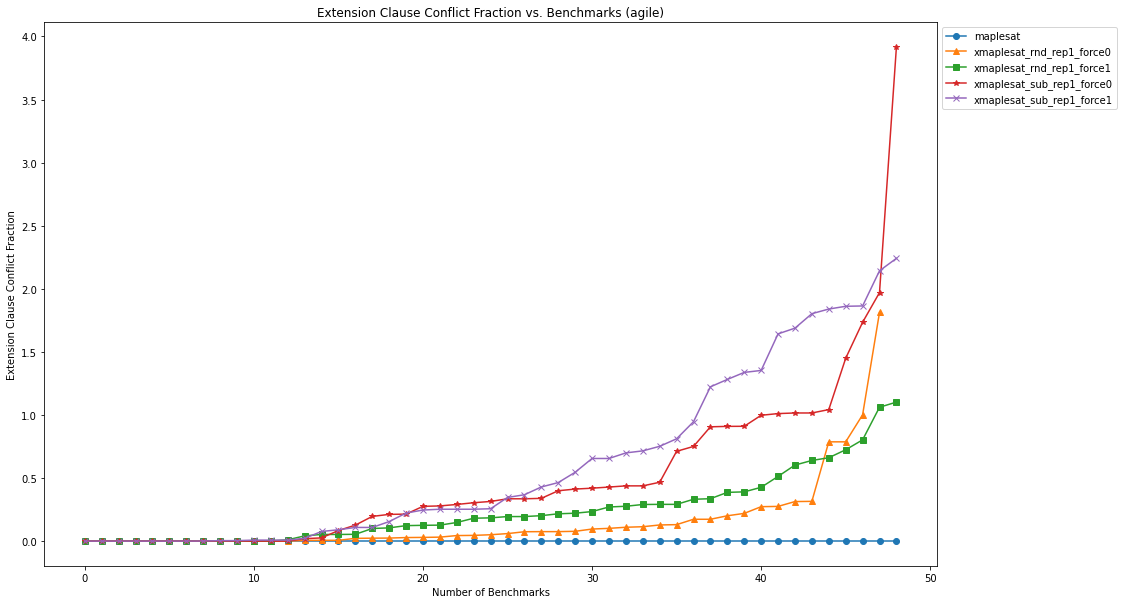

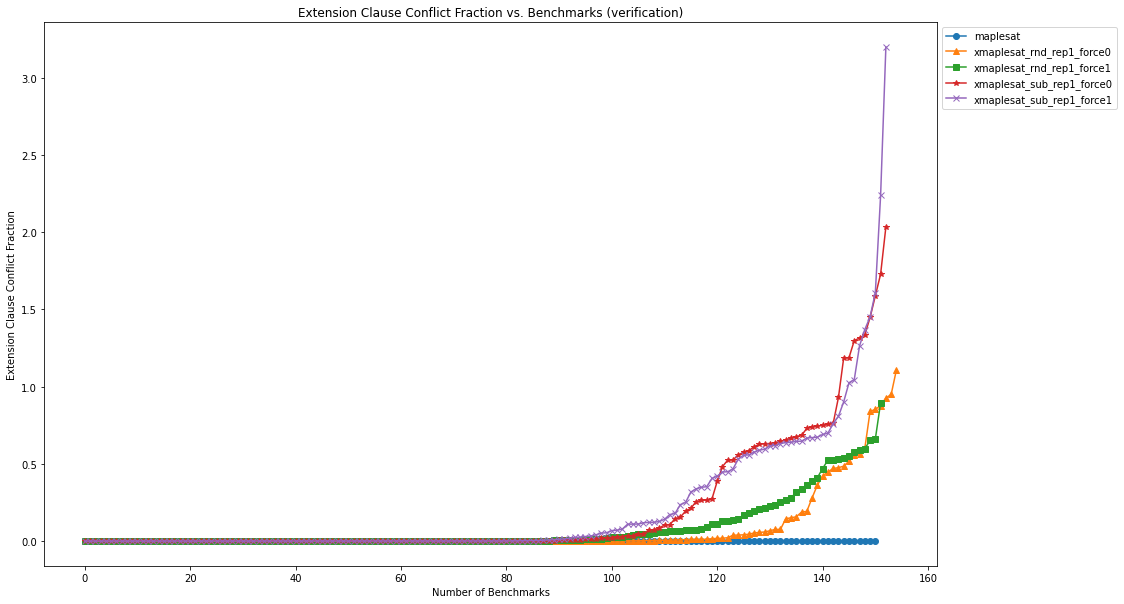

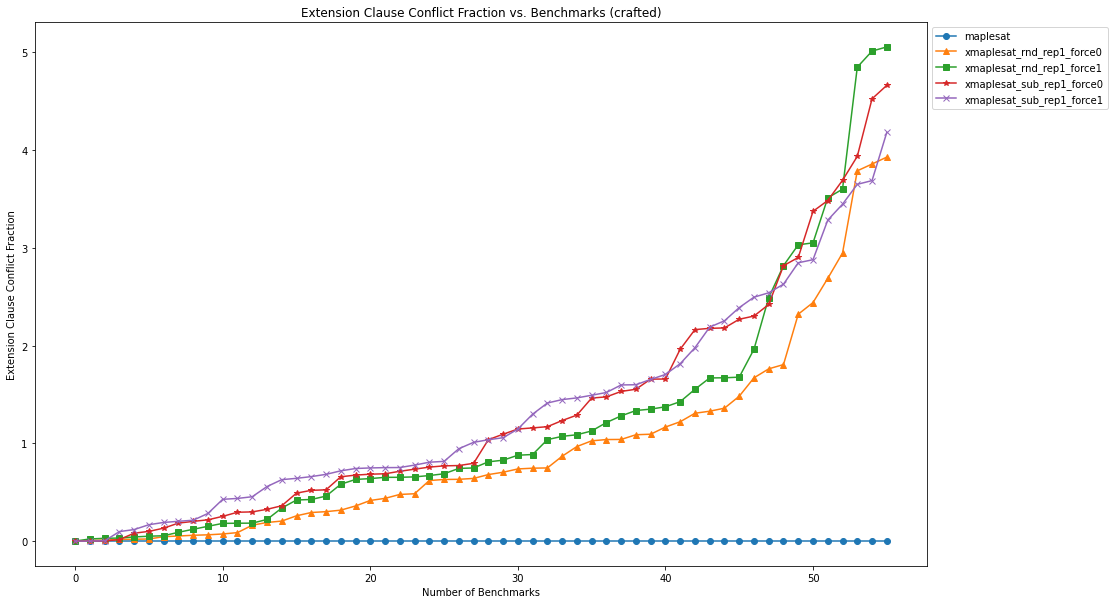

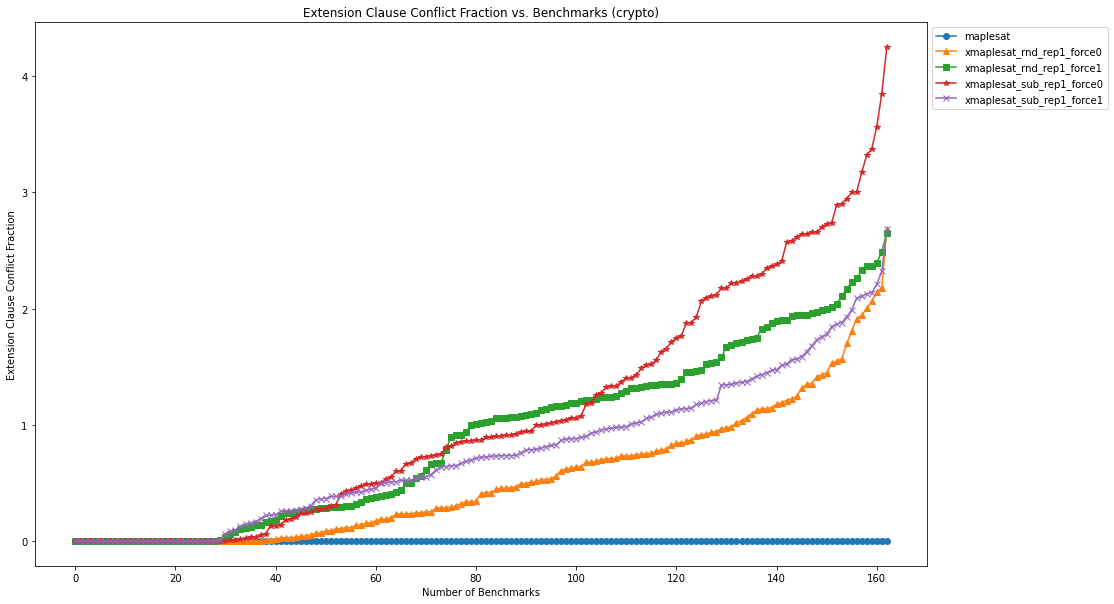

In [15]:
cactusByVariant(solvers, 'ev_conf_frac', 'Extension Clause Conflict Fraction', False)